# I. Designing experiment
## 1. Formulating a hypothesis
Для реализации данного проекта использовался двухвыборочный z-тест для пропорций (дискретное распределение Бернулли).

H0(нулевая гипеотеза): p0=p1      
H1(альтернативная гипотеза): p0≠p1,

где p0 и p1 - вероятности коэффициентов конверсии нового и старого дизайна веб-страницы соответственно. 

Уровень значимости α=0.05

## 2. Choosing the variables
Для реализации данного теста необходимо пользователей разделить на две группы:
1. Control (контрольная группа) - им будет показан старый дизайн веб-страницы;
2. Test (тестовая группа) - им будет показан новый дизайн веб-страницы.

Измеряемая метрика - коэффициент конверсии, который вычисляется на основании действия пользователя на соответствующей веб-странице старого или нового образца:
0 - пользователь не покупал продукт во время посещения веб-страницы;
1 - пользователь купил продукт во время посещения веб-страницы.

Таким образом, есть возможность рассчитать среднее значение коэффициента конверсии для каждой группы.

In [46]:
# Загрузка необходимых библиотек
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# II. Reading Data

In [47]:
df = pd.read_csv('datasets/ab_data_new.csv')
df.sample(10) # возвращает случайные 10 строк

# user_id -  идентификатор пользователя
# timestamp - дата и время посещения веб-страницы
# group - группа, к которой назначен пользователь
# landing_page - информация о том, какую версию сайта пользователь видел
# converted - информация о поведении пользователя: совершил ли пользователь покупку (1) или нет (0)

,user_id,timestamp,group,landing_page,converted
64747,668348,2023-01-13 23:03:00.871707,test,new_page,0
271022,846237,2023-01-08 23:54:39.749796,control,old_page,0
105763,904612,2023-01-06 13:33:32.920018,test,new_page,0
31298,729992,2023-01-09 12:35:58.338542,control,old_page,0
2265,671625,2023-01-06 06:45:36.898059,control,old_page,0
138193,688175,2023-01-14 16:24:48.010241,test,new_page,0
100337,894912,2023-01-11 12:12:53.149893,test,new_page,0
63110,689680,2023-01-21 12:53:33.487486,control,old_page,1
255474,804465,2023-01-07 02:50:55.007712,test,old_page,0
85243,806294,2023-01-06 05:37:13.614177,control,old_page,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


# III. Preparing Data

In [61]:
# Проверка на наличие пользователей в контрольной группе, которые видели новую веб-страницу, и наоборот
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
test,145310,0


In [60]:
# Очистка данных от тех пользователей, которые в контрольной группе видели новую страницу, а в тестовой группе - старую страницу. 
df = df.query('(group == "control" & landing_page == "old_page") | (group == "test" & landing_page == "new_page")')
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
test,145310,0


In [50]:
#Проверка на наличие повторяющихся значений в столбце user_id
df[df.duplicated(['user_id'],keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [51]:
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2023-01-09 05:37:58.781806,test,new_page,0
2893,773192,2023-01-14 02:55:59.590927,test,new_page,0


In [52]:
# Пользователь c user_id = 773192 дважды видел новую страницу и ни разу не совершил конверсию
# Необходимо удалить второй экземпляр для этого пользователя

df = df.drop_duplicates(subset='user_id', keep="first")

# IV. Choosing a sample size 

Конверсия в компании составила 12%. За счёт проектирования новой веб-страницы компания хочет увеличить это число до 14%. 
Чтобы решить, какое количество людей нужно для доказательства или отклонения гипотезы, необходимо провести анализ мощности.

In [53]:
# # Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.12, 0.14)  

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.9,  #power of a test (defualt is 0.8)
    alpha=0.05, #p-value
    ratio=1
    ) # Calculating sample size needed

# Rounding up to next whole number 
required_n = ceil(required_n)                                                 

print(required_n)

5934


Следовательно, нам нужно 5934 пользователя в контрольной группе и 5934 пользователя в тестовой группе.

# V. Sampling
Очистив данные, необходимо произвести выборку, отобрав 5934 ползователя для каждой из групп. Для этого можно воспользоваться методом DataFrame.sample() от pandas, который создаст случайную выборку с нужным числом пользователей.

In [15]:
df.shape

(290584, 5)

In [56]:
control_group = df.query('group == "control"').sample(required_n)
test_group = df.query('group == "test"').sample(required_n)

In [55]:
control_group.head()

,user_id,timestamp,group,landing_page,converted
42957,793518,2023-01-15 05:53:59.745542,control,old_page,0
69519,930514,2023-01-03 00:25:39.031450,control,old_page,0
9455,841660,2023-01-18 18:04:27.983451,control,old_page,0
253116,776611,2023-01-08 15:12:42.220803,control,old_page,0
267702,925258,2023-01-24 02:07:08.180360,control,old_page,1


In [57]:
test_group.head()

,user_id,timestamp,group,landing_page,converted
120148,920313,2023-01-13 02:03:24.178921,test,new_page,0
180088,709476,2023-01-15 22:37:02.722020,test,new_page,0
221438,735933,2023-01-06 21:47:00.083058,test,new_page,0
109152,803476,2023-01-07 10:39:52.175119,test,new_page,0
289487,773406,2023-01-15 14:57:08.427860,test,new_page,0


In [58]:
ab_test = pd.concat([control_group, test_group], axis=0)
ab_test.reset_index(inplace=True, drop=True)

In [59]:
ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,808987,2023-01-20 13:11:42.023461,control,old_page,0
1,927247,2023-01-17 04:45:21.607385,control,old_page,0
2,803690,2023-01-20 01:12:16.309810,control,old_page,0
3,666985,2023-01-12 15:59:02.683733,control,old_page,0
4,886423,2023-01-05 22:28:48.144920,control,old_page,0


In [29]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11868 entries, 0 to 11867
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       11868 non-null  int64 
 1   timestamp     11868 non-null  object
 2   group         11868 non-null  object
 3   landing_page  11868 non-null  object
 4   converted     11868 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 463.7+ KB


In [30]:
ab_test.group.value_counts()

group
control      5934
treatment    5934
Name: count, dtype: int64

# VI. Visualising the results
Расчёт статистических параметров

In [38]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=1)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=1)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg(['mean', std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.119,0.323,0.004
treatment,0.125,0.331,0.004


В контрольной группе коэффициент конверсии составил 11,9%, а в тестовой группе - 12,5%.

Построение графиков:

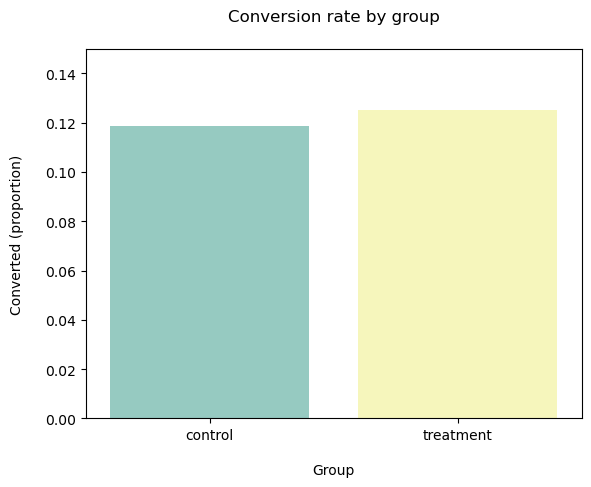

In [42]:
#sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False, palette='Set3')
sns.barplot(x=ab_test['group'], y=ab_test['converted'], errorbar=('ci', False), hue=ab_test['group'], legend=False, palette='Set3')
#sns.barplot(x=ab_test['group'], y=ab_test['converted'], errorbar=('ci', False), palette='Set3')
plt.ylim(0, 0.15)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)
plt.show()

Показатели конверсии в группах очень близки. Также обратите внимание, что показатель конверсии в контрольной группе ниже, чем мы ожидали, учитывая то, что мы знали о нашем среднем показателе конверсии (12,3% против 13%). Это показывает, что при выборке из популяции существует некоторая вариабельность результатов.

Значение конверсии в тестовой группе выше. Необходимо определить, является ли это различие статистически значимым.

# VII. Testing the hypothesis
Предпоследним шагом анализа является проверка нашей гипотезы. Поскольку имеется большая выборка, в которой известно изначальное стандартное отклонение, будем использовать z-статистику.

In [43]:
# воспользуемся модулем statsmodels.stats.proportion,
# чтобы получить p-значение и доверительные интервалы
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [44]:
control_conversion = ab_test.query('group == "control"')['converted']
treatment_conversion = ab_test.query('group == "treatment"')['converted']

In [45]:
nobs = [control_conversion.count(), treatment_conversion.count()]
successes = [control_conversion.sum(), treatment_conversion.sum()]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'95% Confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% Confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.09
p-value: 0.274
95% Confidence interval for control group: [0.110, 0.127]
95% Confidence interval for treatment group: [0.117, 0.134]


# VIII.  Drawing conclusions
Несмотря на то, что на первый взгляд коэффициент конверсии в тестовой группе оказался немного выше, значение p>0,05, поэтому нет возможностей отклонить нулевую гипотезу. Кроме того, доверительные интервалы включают наше базовое значение коэффициента конверсии в 12%.

Таким образом, эта новая версия сайта не может существенно увеличить конверсию. По результатам A/B-теста мы пришли к выводу, что компании нет смысла внедрять новую версию сайта.